In [1]:
import torch
import triton
import triton.language as tl

In [2]:
DEVICE = torch.device("cuda:0")

### Triton Add kernel
We define the Triton add kernel here. The programming model of Triton allows us to operate on blocks of numbers. A triton kernel is annotated with `@triton.jit` and mostly follows a pretty intuitive flow.

In [3]:
@triton.jit
def add_kernel(x_ptr: torch.Tensor,
               y_ptr: torch.Tensor,
               output_ptr: torch.Tensor,
               num_elements: int,
               BLOCK_SIZE: tl.constexpr,
               ):
    """
    Computes vector addition of x_ptr + y_ptr block wise.
    
    Args:
        x_ptr: pointer to the first input torch tensor.
        y_ptr: pointer to the second input torch tensor.
        output_ptr: pointer to the output torch tensor.
        num_elements: Number of elements in the input arrays.
        BLOCK_SIZE: Number of elements each program should process.
            type is constexpr, so it can be used as a shape value.
    """
    pid = tl.program_id(axis=0) # get the current pid.
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE) # we add the block_start to the offsets within a block, to get the global offsets.
    mask = offsets < num_elements # we only process the elements within our num_elements limit.
    x = tl.load(x_ptr + offsets, mask=mask) # load a block of x_ptr from DRAM
    y = tl.load(y_ptr + offsets, mask=mask) # load a block of y_ptr from DRAM
    out = x + y
    tl.store(output_ptr + offsets, out, mask=mask) # store the block back to DRAM.

#### Kernel Wrapper
Now we need a kernel wrapper which will allocate the output tensor on the correct device and launch the kernel with the correct config

In [4]:
def add(x: torch.Tensor,
        y: torch.Tensor):
    output = torch.empty_like(x, device=x.device)
    assert x.shape == y.shape, f"x and y shapes should match, got: {x.shape=} and {y.shape=}"
    assert x.device.type == DEVICE.type and x.device.index == DEVICE.index and \
       y.device.type == DEVICE.type and y.device.index == DEVICE.index and \
       output.device.type == DEVICE.type and output.device.index == DEVICE.index, \
       f"Devices mismatch: {x.device=}, {y.device=}, {output.device=}"
    num_elements = output.numel()
    # Like CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    grid = lambda meta: (triton.cdiv(num_elements, meta['BLOCK_SIZE']), )
    # We pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, num_elements, BLOCK_SIZE=1024)
    # Note: We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output
    

### Testing code

In [5]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')


tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


### Benchmarking
Triton has a built set of utilities that allow us to generate perf reports and plot the performance of our custom ops.

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

#### Run Benchmark
Now we run the benchmark and plot the results

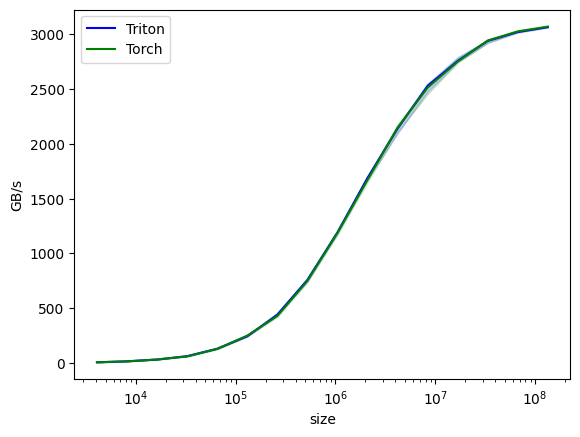

vector-add-performance:
           size       Triton        Torch
0        4096.0     8.827586     8.777143
1        8192.0    17.554286    17.454545
2       16384.0    33.758241    34.516854
3       32768.0    64.673682    62.375634
4       65536.0   132.129029   130.723400
5      131072.0   245.760006   251.416874
6      262144.0   442.810806   431.157886
7      524288.0   759.104267   750.412251
8     1048576.0  1191.563601  1187.963788
9     2097152.0  1687.622326  1669.706983
10    4194304.0  2137.043431  2145.789924
11    8388608.0  2526.689054  2510.557073
12   16777216.0  2753.372505  2747.360729
13   33554432.0  2935.817052  2939.246129
14   67108864.0  3016.399869  3022.377330
15  134217728.0  3060.604977  3066.198484


In [7]:
benchmark.run(print_data=True, show_plots=True)